In [3]:
import pandas as pd
from typing import List, Optional
import re
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import levene
from pingouin import welch_anova
from rpy2.robjects import pandas2ri, r
from rpy2.robjects.packages import importr
pandas2ri.activate()

pd.options.mode.chained_assignment = None  # default='warn'

ARTool = importr('ARTool')
base = importr('base')
stats = importr('stats')

In [5]:
def read_gsheet(url: Optional[str]=None, sheet_id: Optional[str]=None, gid: Optional[str]=None):
    if url is not None:
        match = re.search(r"spreadsheets/d/([^/]+)/.*?[?&]gid=(\d+)", url)
        if match:
            sheet_id = match.group(1)
            gid = match.group(2)
        else:
            print("can't parse url to get sheet id and gid")
    else:
        assert sheet_id is not None and gid is not None, "Sheet id an gid must be not None when url is not None"
    _url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&id={sheet_id}&gid={gid}"
    return pd.read_csv(_url)

In [6]:
def multi_way_anova(_filter_df: pd.DataFrame, independent_vars: Optional[List[str]] = ["fine_tune_dataset"],
                    dependent_var: Optional[str] = "output_x", collapse: bool=True):
    """
    do multi way anova on the provided dataframe.
    :param _filter_df: output from a model
    :param dependent_var: predicted variable (column name in the df)
    :param independent_vars: contributing factors
    :param collapse: instead of saying which dataset it is finetuned on, we will just have 2 values
    for this factor -- whether it is finetuned or not
    :return:
    """
    if collapse:
        mapping = {'Base': 'Base'}
        _filter_df.loc[:, 'fine_tune_dataset'] = _filter_df['fine_tune_dataset'].map(mapping).fillna('fine_tuned')
    # print(f"df size: {_filter_df.shape}")
    # levene
    grouped_data =  _filter_df.groupby(independent_vars)[dependent_var].apply(list)
    stat, pval = levene(*grouped_data, center='mean')
    print(f"Levene’s Test: Statistic = {stat:.4f}, p-value = {pval:.4g}")
    if pval < 0.05: # pval must be < 0.05 for us to reject the H_0 at Levenes.
        print("Robust ANOVA")
        r_df = pandas2ri.py2rpy(_filter_df)
        r.assign("rdf", r_df)

        for var in independent_vars:
            r(f"rdf${var} <- as.factor(rdf${var})")
        formula_str = f"{dependent_var} ~ {' * '.join(independent_vars)}"
        r(f'''
            library(ARTool)
            model <- art({formula_str}, data = rdf)
            art_result <- anova(model, type=2)
        ''')

        art_result = r('art_result')
        art_df = pandas2ri.rpy2py(art_result)
        return art_df
    formula = f"{dependent_var} ~" + ' + '.join([f'C({col})' for col in independent_vars])
    _model = ols(formula, data=_filter_df).fit()
    anova_table = sm.stats.anova_lm(_model, typ=2)
    anova_table['eta_sq'] = anova_table['sum_sq'] / anova_table['sum_sq'].sum()
    return anova_table


In [8]:
def one_way_anova(_filter_df: pd.DataFrame, independent_var: Optional[str] = "fine_tune_dataset",
                  dependent_var: Optional[str] = "output_x", collapse: bool=True):
    """
    do one way anova on the provided dataframe.
    :param _filter_df: output from a model
    :param dependent_var: predicted variable (column name in the df)
    :param independent_var: contributing factor
    :param collapse: instead of saying which dataset it is finetuned on, we will just have 2 values
    for this factor -- whether it is finetuned or not
    :return:
    """
    #print(f"df size: {_filter_df.shape}")
    # suppose the independent variable is prompt, then, it is possible that the dependent variable has the same value for all the prompts. 
    # in that case, we should filter out those rows as the variance will be zero.
    grouped_data = _filter_df.groupby(independent_var)
    for group_name, group in grouped_data:
        if group[dependent_var].nunique() <= 1:
            print(f"Group '{group_name}' has only one unique value for '{dependent_var}', removing it from analysis.")
            _filter_df = _filter_df[_filter_df[independent_var] != group_name]
    #print(f"df size after filtering: {_filter_df.shape}")
    mapping = {'Base': 'Base'}
    _filter_df.loc[:, 'fine_tune_dataset'] = _filter_df['fine_tune_dataset'].map(mapping).fillna('fine_tuned')
    # levene
    grouped_data = [group[dependent_var].values for name, group in _filter_df.groupby(independent_var)]
    grouped_data = [group for group in grouped_data if len(group) > 1 and len(set(group)) > 1]  
    # filter out groups with only one observation and groups with no variance
    stat, pval = levene(*grouped_data, center='mean')
    print(f"Levene’s Test: Statistic = {stat:.4f}, p-value = {pval:.4g}")
    if pval < 0.05:
        print("Welch")
        assert independent_var is not None and dependent_var is not None
        if len(set(_filter_df[independent_var])) < 2:
            print(f"Only one level of {independent_var} found, returning empty DataFrame.")
            return pd.DataFrame(columns=['F', 'PR(>F)', 'sum_sq', 'df', 'mean_sq', 'eta_sq'])
        welch_results = welch_anova(dv=dependent_var, between=independent_var, data=_filter_df)
        return welch_results
    formula=f"{dependent_var} ~ C({independent_var})"
    _model = ols(formula, data=_filter_df).fit()
    anova_table = sm.stats.anova_lm(_model, typ=2)
    anova_table['eta_sq'] = anova_table['sum_sq'] / anova_table['sum_sq'].sum()
    return anova_table


## Fine-tuning data analysis

In [9]:
url = "https://docs.google.com/spreadsheets/d/1Opmxs3CoUepJTnPSQSwkztpiMnpda5RO7dMt1p-uSjc/edit?gid=0#gid=0"
df = read_gsheet(url=url)
print(len(df))
df = df.drop_duplicates()
df = df[df.model != "Phi"]  # filter out Phi
print(set(df['fine_tune_dataset']))
df['prompt'] = df['prompt'].astype(str)
print(len(df))


2704
{'Newsroom', 'Pol-Convo', 'Imdb', 'FineTome', 'Newsarticles', 'Base', 'Canadian-QA', 'OpenR1', 'Scisumm'}
2704


In [10]:
## fine tuning data analysis

model_split_df = {}

columns = {}
columns['equality'] = "Equality"
columns['nation'] = "Nation"
columns['liberty'] = "Liberty"
columns['tradition'] = "Tradition"


for model in set(df['model']):
    _df = df[(df['model']== model)]
    _df.rename(columns={v:k for k,v in columns.items()}, inplace=True)
    print(model, len(_df))
    model_split_df[model] = _df

print(set(df['model']))
models = ["Gemma", "Llama", "Falcon", "Mistral"]
dependent_vars = ["equality", "nation", "liberty", "tradition"]


Mistral 624
Falcon 640
Gemma 720
Llama 720
{'Mistral', 'Falcon', 'Gemma', 'Llama'}


### indepent t-test

determine if we have a difference between fine-tuned and base versions of PCT

In [11]:
from scipy.stats import ttest_ind

def t_test(_df: pd.DataFrame, _dependent_var: str):
    _df['is_finetuned'] = _df['fine_tune_dataset'].apply(lambda x: 'Base' not in x)
    base_dep_var = _df[_df['is_finetuned'] == False][_dependent_var]
    finetuned_dep_var = _df[_df['is_finetuned'] == True][_dependent_var]
    t_stat, p_value = ttest_ind(base_dep_var, finetuned_dep_var, equal_var=False)
    return (t_stat, p_value)    

for dependent_var in dependent_vars:
    print("=:"*20+f" {dependent_var} "+"=:"*20)
    for model in models:
        print("-"*20+f" {model} "+"-"*20)
        print(t_test(_df=model_split_df[model], _dependent_var = dependent_var))

=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=: equality =:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:
-------------------- Gemma --------------------
(np.float64(3.445037938169432), np.float64(0.0007143452507412387))
-------------------- Llama --------------------
(np.float64(9.214477762737376), np.float64(6.336468431972676e-16))
-------------------- Falcon --------------------
(np.float64(2.13696051014108), np.float64(0.03496639550602328))
-------------------- Mistral --------------------
(np.float64(17.333548248885045), np.float64(2.790324765636237e-45))
=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=: nation =:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:
-------------------- Gemma --------------------
(np.float64(-8.359304209499095), np.float64(1.305173861716123e-13))
-------------------- Llama --------------------
(np.float64(-10.993021816379697), np.float64(2.744664480111562e-20))
-------------------- Falcon --------------------
(np.float64(5.70406868836131), np.float64(6.292275010039787e-08))
-----------

In [12]:
## code to convert it to csv format
import csv
import re
from io import StringIO

text = """
=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=: equality =:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:
-------------------- Gemma --------------------
(np.float64(3.445037938169432), np.float64(0.0007143452507412387))
-------------------- Llama --------------------
(np.float64(9.214477762737376), np.float64(6.336468431972676e-16))
-------------------- Falcon --------------------
(np.float64(2.13696051014108), np.float64(0.03496639550602328))
-------------------- Mistral --------------------
(np.float64(17.333548248885045), np.float64(2.790324765636237e-45))
=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=: nation =:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:
-------------------- Gemma --------------------
(np.float64(-8.359304209499095), np.float64(1.305173861716123e-13))
-------------------- Llama --------------------
(np.float64(-10.993021816379697), np.float64(2.744664480111562e-20))
-------------------- Falcon --------------------
(np.float64(5.70406868836131), np.float64(6.292275010039787e-08))
-------------------- Mistral --------------------
(np.float64(-5.6923962761889895), np.float64(6.90654382765598e-08))
=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=: liberty =:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:
-------------------- Gemma --------------------
(np.float64(3.899597467960902), np.float64(0.00013718523586780544))
-------------------- Llama --------------------
(np.float64(4.7165302384789145), np.float64(5.882921437759474e-06))
-------------------- Falcon --------------------
(np.float64(-12.737049789428227), np.float64(3.724435110127161e-30))
-------------------- Mistral --------------------
(np.float64(6.76496937797683), np.float64(3.0841286353248504e-10))
=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=: tradition =:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:
-------------------- Gemma --------------------
(np.float64(-7.224074390295039), np.float64(1.8820870629987625e-11))
-------------------- Llama --------------------
(np.float64(4.730673283743898), np.float64(3.6144304742339855e-06))
-------------------- Falcon --------------------
(np.float64(5.3790714112775815), np.float64(2.2273282963053842e-07))
-------------------- Mistral --------------------
(np.float64(0.18721539457697195), np.float64(0.8516255138208897))
"""

# Extract results
def extract_results(section_text):
    pattern = r"-{5,}\s*(\w+)\s*-{5,}.*?\(np\.float64\(([-+eE\d\.]+)\), np\.float64\(([-+eE\d\.]+)\)\)"
    return {x[0]: (x[1], x[2]) for x in re.findall(pattern, section_text, re.DOTALL)}

# Split sections
output_equality = text.split("equality =")[-1].split("nation =")[0]
output_nation = text.split("nation =")[-1].split("liberty =")[0]
output_liberty = text.split("liberty =")[-1].split("tradition =")[0]
output_tradition = text.split("tradition =")[-1]

x_results = extract_results(output_equality)
y_results = extract_results(output_nation)
z_results = extract_results(output_liberty)
w_results = extract_results(output_tradition)

rows = []
for model in models:
    x_stat, x_p = x_results.get(model, ("", ""))
    y_stat, y_p = y_results.get(model, ("", ""))
    z_stat, z_p = z_results.get(model, ("", ""))
    w_stat, w_p = w_results.get(model, ("", ""))
    rows.append([model, "{:.2e}".format(float(x_stat)), "{:.2e}".format(float(x_p)), 
                 "{:.2e}".format(float(y_stat)), "{:.2e}".format(float(y_p)),
                 "{:.2e}".format(float(z_stat)), "{:.2e}".format(float(z_p)),
                 "{:.2e}".format(float(w_stat)), "{:.2e}".format(float(w_p))])

# Write CSV
with open("t_stats_8values.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["model", "t-stat-equality", "p-value", "t-stat-nation", "p-value", "t-stat-liberty", "p-value", "t-stat-tradition", "p-value"])
    writer.writerows(rows)
print("text written")

text written


### multi way anova to understand the joint effect of prompts and fine-tune dataset

In [13]:
for dependent_var in dependent_vars:
    print("=:"*20+f" {dependent_var} "+"=:"*20)
    for model in models:
        print("-"*20+f" {model} "+"-"*20)
        print(multi_way_anova(_filter_df=model_split_df[model], independent_vars= ["prompt", "fine_tune_dataset"], dependent_var = dependent_var, collapse=True))

=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=: equality =:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:
-------------------- Gemma --------------------
Levene’s Test: Statistic = 5.7915, p-value = 1.279e-13
Robust ANOVA
                                              Term   Df  Df.res        Sum Sq  \
prompt                                      prompt  9.0   700.0  2.726847e+06   
fine_tune_dataset                fine_tune_dataset  1.0   700.0  2.198548e+05   
prompt:fine_tune_dataset  prompt:fine_tune_dataset  9.0   700.0  8.361772e+05   

                            Sum Sq.res   F value        Pr(>F)  
prompt                    2.828238e+07  7.498948  1.612655e-10  
fine_tune_dataset         3.081167e+07  4.994806  2.573824e-02  
prompt:fine_tune_dataset  3.016179e+07  2.156238  2.324845e-02  
-------------------- Llama --------------------
Levene’s Test: Statistic = 3.4812, p-value = 8.996e-07
Robust ANOVA
                                              Term   Df  Df.res        Sum Sq  \
prompt     

In [14]:
## convert the results to csv format
equality_text = """
-------------------- Gemma --------------------
Levene’s Test: Statistic = 5.7915, p-value = 1.279e-13
Robust ANOVA
                                              Term   Df  Df.res        Sum Sq  \
prompt                                      prompt  9.0   700.0  2.726847e+06   
fine_tune_dataset                fine_tune_dataset  1.0   700.0  2.198548e+05   
prompt:fine_tune_dataset  prompt:fine_tune_dataset  9.0   700.0  8.361772e+05   

                            Sum Sq.res   F value        Pr(>F)  
prompt                    2.828238e+07  7.498948  1.612655e-10  
fine_tune_dataset         3.081167e+07  4.994806  2.573824e-02  
prompt:fine_tune_dataset  3.016179e+07  2.156238  2.324845e-02  
-------------------- Llama --------------------
Levene’s Test: Statistic = 3.4812, p-value = 8.996e-07
Robust ANOVA
                                              Term   Df  Df.res        Sum Sq  \
prompt                                      prompt  9.0   700.0  2.098898e+06   
fine_tune_dataset                fine_tune_dataset  1.0   700.0  2.382782e+06   
prompt:fine_tune_dataset  prompt:fine_tune_dataset  9.0   700.0  8.036404e+05   

                            Sum Sq.res    F value        Pr(>F)  
prompt                    2.894764e+07   5.639410  1.494945e-07  
fine_tune_dataset         2.866938e+07  58.178714  7.831566e-14  
prompt:fine_tune_dataset  3.021335e+07   2.068800  3.012183e-02  
-------------------- Falcon --------------------
Levene’s Test: Statistic = 6.2930, p-value = 5.661e-15
Robust ANOVA
                                              Term   Df  Df.res        Sum Sq  \
prompt                                      prompt  9.0   620.0  4.921209e+06   
fine_tune_dataset                fine_tune_dataset  1.0   620.0  1.748926e+05   
prompt:fine_tune_dataset  prompt:fine_tune_dataset  9.0   620.0  1.765869e+05   

                            Sum Sq.res    F value        Pr(>F)  
prompt                    1.685099e+07  20.118498  8.428324e-30  
fine_tune_dataset         2.153769e+07   5.034588  2.519814e-02  
prompt:fine_tune_dataset  2.158093e+07   0.563686  8.271913e-01  
-------------------- Mistral --------------------
Levene’s Test: Statistic = 11.2742, p-value = 2.174e-29
Robust ANOVA
                                              Term   Df  Df.res        Sum Sq  \
prompt                                      prompt  9.0   604.0  2.225685e+06   
fine_tune_dataset                fine_tune_dataset  1.0   604.0  3.133460e+06   
prompt:fine_tune_dataset  prompt:fine_tune_dataset  9.0   604.0  4.534909e+05   

                            Sum Sq.res     F value        Pr(>F)  
prompt                    1.798771e+07    8.303904  1.030418e-11  
fine_tune_dataset         1.707648e+07  110.831368  6.544226e-24  
prompt:fine_tune_dataset  1.974561e+07    1.541319  1.298375e-01  
"""

nation_text = """
-------------------- Gemma --------------------
Levene’s Test: Statistic = 8.1098, p-value = 1.215e-20
Robust ANOVA
                                              Term   Df  Df.res        Sum Sq  \
prompt                                      prompt  9.0   700.0  4.376517e+06   
fine_tune_dataset                fine_tune_dataset  1.0   700.0  2.369256e+06   
prompt:fine_tune_dataset  prompt:fine_tune_dataset  9.0   700.0  1.275562e+06   

                            Sum Sq.res    F value        Pr(>F)  
prompt                    2.667159e+07  12.762485  6.334367e-19  
fine_tune_dataset         2.855663e+07  58.076846  8.215088e-14  
prompt:fine_tune_dataset  2.966879e+07   3.343932  5.104144e-04  
-------------------- Llama --------------------
Levene’s Test: Statistic = 3.3290, p-value = 2.421e-06
Robust ANOVA
                                              Term   Df  Df.res        Sum Sq  \
prompt                                      prompt  9.0   700.0  3.031017e+05   
fine_tune_dataset                fine_tune_dataset  1.0   700.0  3.125369e+06   
prompt:fine_tune_dataset  prompt:fine_tune_dataset  9.0   700.0  1.127090e+06   

                            Sum Sq.res    F value        Pr(>F)  
prompt                    3.078845e+07   0.765696  6.483862e-01  
fine_tune_dataset         2.793583e+07  78.313705  7.123718e-18  
prompt:fine_tune_dataset  2.993284e+07   2.928640  2.041109e-03  
-------------------- Falcon --------------------
Levene’s Test: Statistic = 5.7244, p-value = 2.789e-13
Robust ANOVA
                                              Term   Df  Df.res        Sum Sq  \
prompt                                      prompt  9.0   620.0  1.921246e+06   
fine_tune_dataset                fine_tune_dataset  1.0   620.0  4.005979e+05   
prompt:fine_tune_dataset  prompt:fine_tune_dataset  9.0   620.0  1.793001e+05   

                            Sum Sq.res    F value        Pr(>F)  
prompt                    1.976580e+07   6.696038  3.497389e-09  
fine_tune_dataset         2.129294e+07  11.664462  6.786625e-04  
prompt:fine_tune_dataset  2.148311e+07   0.574953  8.181510e-01  
-------------------- Mistral --------------------
Levene’s Test: Statistic = 9.1994, p-value = 1.793e-23
Robust ANOVA
                                              Term   Df  Df.res        Sum Sq  \
prompt                                      prompt  9.0   604.0  1.251205e+06   
fine_tune_dataset                fine_tune_dataset  1.0   604.0  6.167478e+05   
prompt:fine_tune_dataset  prompt:fine_tune_dataset  9.0   604.0  1.024221e+06   

                            Sum Sq.res    F value    Pr(>F)  
prompt                    1.896052e+07   4.428664  0.000012  
fine_tune_dataset         1.956659e+07  19.038352  0.000015  
prompt:fine_tune_dataset  1.916384e+07   3.586788  0.000231  
"""

liberty_text = """
-------------------- Gemma --------------------
Levene’s Test: Statistic = 9.7240, p-value = 1.791e-25
Robust ANOVA
                                              Term   Df  Df.res        Sum Sq  \
prompt                                      prompt  9.0   700.0  8.734504e+06   
fine_tune_dataset                fine_tune_dataset  1.0   700.0  2.813587e+05   
prompt:fine_tune_dataset  prompt:fine_tune_dataset  9.0   700.0  1.000707e+06   

                            Sum Sq.res    F value        Pr(>F)  
prompt                    2.232694e+07  30.427377  5.542028e-45  
fine_tune_dataset         3.071099e+07   6.413050  1.154592e-02  
prompt:fine_tune_dataset  3.006898e+07   2.588473  6.126808e-03  
-------------------- Llama --------------------
Levene’s Test: Statistic = 3.7303, p-value = 1.743e-07
Robust ANOVA
                                              Term   Df  Df.res        Sum Sq  \
prompt                                      prompt  9.0   700.0  7.396102e+05   
fine_tune_dataset                fine_tune_dataset  1.0   700.0  6.569610e+05   
prompt:fine_tune_dataset  prompt:fine_tune_dataset  9.0   700.0  1.053423e+06   

                            Sum Sq.res    F value    Pr(>F)  
prompt                    3.034109e+07   1.895952  0.049617  
fine_tune_dataset         3.039991e+07  15.127435  0.000110  
prompt:fine_tune_dataset  3.000626e+07   2.730528  0.003889  
-------------------- Falcon --------------------
Levene’s Test: Statistic = 8.7122, p-value = 3.931e-22
Robust ANOVA
                                              Term   Df  Df.res        Sum Sq  \
prompt                                      prompt  9.0   620.0  1.795760e+06   
fine_tune_dataset                fine_tune_dataset  1.0   620.0  1.883358e+06   
prompt:fine_tune_dataset  prompt:fine_tune_dataset  9.0   620.0  4.549089e+05   

                            Sum Sq.res    F value        Pr(>F)  
prompt                    1.988920e+07   6.219852  1.977477e-08  
fine_tune_dataset         1.968142e+07  59.329170  5.302777e-14  
prompt:fine_tune_dataset  2.110280e+07   1.485024  1.495958e-01  
-------------------- Mistral --------------------
Levene’s Test: Statistic = 12.0614, p-value = 1.384e-31
Robust ANOVA
                                              Term   Df  Df.res        Sum Sq  \
prompt                                      prompt  9.0   604.0  1.076232e+06   
fine_tune_dataset                fine_tune_dataset  1.0   604.0  7.366785e+05   
prompt:fine_tune_dataset  prompt:fine_tune_dataset  9.0   604.0  8.167706e+05   

                            Sum Sq.res    F value    Pr(>F)  
prompt                    1.906839e+07   3.787795  0.000116  
fine_tune_dataset         1.949502e+07  22.823976  0.000002  
prompt:fine_tune_dataset  1.939441e+07   2.826298  0.002906
"""

tradition_text = """
-------------------- Gemma --------------------
Levene’s Test: Statistic = 7.7240, p-value = 1.774e-19
Robust ANOVA
                                              Term   Df  Df.res        Sum Sq  \
prompt                                      prompt  9.0   700.0  1.109152e+07   
fine_tune_dataset                fine_tune_dataset  1.0   700.0  1.965371e+06   
prompt:fine_tune_dataset  prompt:fine_tune_dataset  9.0   700.0  2.470409e+06   

                            Sum Sq.res    F value        Pr(>F)  
prompt                    1.997010e+07  43.198284  1.397884e-61  
fine_tune_dataset         2.907134e+07  47.323560  1.336644e-11  
prompt:fine_tune_dataset  2.854520e+07   6.731182  2.736331e-09  
-------------------- Llama --------------------
Levene’s Test: Statistic = 4.9623, p-value = 4.046e-11
Robust ANOVA
                                              Term   Df  Df.res  \
prompt                                      prompt  9.0   700.0   
fine_tune_dataset                fine_tune_dataset  1.0   700.0   
prompt:fine_tune_dataset  prompt:fine_tune_dataset  9.0   700.0   

                                 Sum Sq    Sum Sq.res    F value    Pr(>F)  
prompt                    412082.145833  3.064986e+07   1.045709  0.401613  
fine_tune_dataset         588123.126563  3.046684e+07  13.512599  0.000255  
prompt:fine_tune_dataset  688067.018924  3.033484e+07   1.764187  0.071653  
-------------------- Falcon --------------------
Levene’s Test: Statistic = 13.5853, p-value = 6.384e-36
Robust ANOVA
                                              Term   Df  Df.res        Sum Sq  \
prompt                                      prompt  9.0   620.0  2.155445e+06   
fine_tune_dataset                fine_tune_dataset  1.0   620.0  3.551917e+05   
prompt:fine_tune_dataset  prompt:fine_tune_dataset  9.0   620.0  2.525440e+05   

                            Sum Sq.res    F value        Pr(>F)  
prompt                    1.957793e+07   7.584369  1.368145e-10  
fine_tune_dataset         2.134329e+07  10.317946  1.385652e-03  
prompt:fine_tune_dataset  2.143501e+07   0.811638  6.056107e-01  
-------------------- Mistral --------------------
Levene’s Test: Statistic = 4.7932, p-value = 1.681e-10
Robust ANOVA
                                              Term   Df  Df.res        Sum Sq  \
prompt                                      prompt  9.0   604.0  2.643219e+06   
fine_tune_dataset                fine_tune_dataset  1.0   604.0  1.049732e+02   
prompt:fine_tune_dataset  prompt:fine_tune_dataset  9.0   604.0  5.424615e+05   

                            Sum Sq.res    F value        Pr(>F)  
prompt                    1.755333e+07  10.105741  1.483741e-14  
fine_tune_dataset         2.018733e+07   0.003141  9.553264e-01  
prompt:fine_tune_dataset  1.962662e+07   1.854889  5.602415e-02  
"""

def return_dependent_var_df(text, dependent_var):
    blocks = re.split(r'-{10,} (.+?) -{10,}', text)[1:]
    
    # Prepare CSV structure
    results = []
    
    for i in range(0, len(blocks), 2):
        model = blocks[i].strip()
        content = blocks[i + 1].strip()
    
        # Find lines containing the ANOVA results
        lines = content.strip().split('\n')
        anova_lines = [
            line.strip()
            for line in lines
            if line.strip().startswith("prompt") or
               line.strip().startswith("fine_tune_dataset") or
               line.strip().startswith("prompt:fine_tune_dataset")
        ]
    
        # Dictionary to hold the output row
        row = {"model": model}
    
        for line in anova_lines:
            parts = re.split(r'\s{2,}', line.strip())
            if len(parts) < 3:
                continue  # Not enough fields
    
            term = parts[0]
            f_value = parts[-2]
            p_value = parts[-1]
    
            if term == "prompt":
                row[f"{dependent_var}-prompt-f-score"] = f"{float(f_value):.2e}"
                row[f"{dependent_var}-prompt-p-value"] = f"{float(p_value):.2e}"
            elif term == "fine_tune_dataset":
                row[f"{dependent_var}-finetune-f-score"] = f"{float(f_value):.2e}"
                row[f"{dependent_var}-finetune-p-value"] = f"{float(p_value):.2e}"
            elif term == "prompt:fine_tune_dataset":
                row[f"{dependent_var}-prompt-finetune-interaction-f-score"] = f"{float(f_value):.2e}"
                row[f"{dependent_var}-prompt-finetune-interaction-p-value"] = f"{float(p_value):.2e}"
        results.append(row)

    return pd.DataFrame(results, columns=["model", f"{dependent_var}-prompt-f-score",
                                          f"{dependent_var}-prompt-p-value",
                                         f"{dependent_var}-finetune-f-score",
                                         f"{dependent_var}-finetune-p-value",
                                         f"{dependent_var}-prompt-finetune-interaction-f-score",
                                         f"{dependent_var}-prompt-finetune-interaction-p-value"])

df_equality = return_dependent_var_df(equality_text, dependent_var="equality")
df_nation = return_dependent_var_df(nation_text, dependent_var="nation")
df_liberty = return_dependent_var_df(liberty_text, dependent_var="liberty")
df_tradition = return_dependent_var_df(tradition_text, dependent_var="tradition")
stacked = pd.concat([df_equality, df_nation, df_liberty, df_tradition], axis=1)
stacked.to_csv("multi_way_anova_results_8_values.csv", index=False)
print(f"output written")

output written


### Does the type of fine-tuning dataset make a difference?

Check if the type of the fine-tuning dataset makes a difference. We need to re-download the data because we have converted all fine-tuning datasets to "fine_tuned" in the last step.

In [15]:
url = "https://docs.google.com/spreadsheets/d/1Opmxs3CoUepJTnPSQSwkztpiMnpda5RO7dMt1p-uSjc/edit?gid=0#gid=0"
df = read_gsheet(url=url)
print(len(df))
df = df.drop_duplicates()
df = df[df.model != "Phi"]  # filter out Phi
print(set(df['fine_tune_dataset']))
df['prompt'] = df['prompt'].astype(str)
print(len(df))


model_split_df = {}

columns = {}
columns['equality'] = "Equality"
columns['nation'] = "Nation"
columns['liberty'] = "Liberty"
columns['tradition'] = "Tradition"


for model in set(df['model']):
    _df = df[(df['model']== model)]
    _df.rename(columns={v:k for k,v in columns.items()}, inplace=True)
    print(model, len(_df))
    model_split_df[model] = _df

print(set(df['model']))
models = ["Gemma", "Llama", "Falcon", "Mistral"]
dependent_vars = ["equality", "nation", "liberty", "tradition"]


2704
{'Newsroom', 'Pol-Convo', 'Imdb', 'FineTome', 'Newsarticles', 'Base', 'Canadian-QA', 'OpenR1', 'Scisumm'}
2704
Mistral 624
Falcon 640
Gemma 720
Llama 720
{'Mistral', 'Falcon', 'Gemma', 'Llama'}


In [16]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
dataset_category = {"target": {'Canadian-QA', 'Newsarticles', 'Newsroom', 'Pol-Convo'}, "control": {"Imdb", "OpenR1", "Scisumm", "FineTome"}}
# we will test the fuck all 
def tukey_test(_df, _dependent_var='output_x'):
    _df = _df[_df['fine_tune_dataset'] != 'Base']
    #print(len(_df), list(_df), set(_df['fine_tune_dataset']))
    _df['dataset_group'] = _df['fine_tune_dataset'].apply(lambda x: 'target' if x in dataset_category["target"] else "control")
    #model = ols(f'{_dependent_var} ~ C(prompt) + C(fine_tune_dataset) + C(prompt):C(fine_tune_dataset)', data=_df).fit()
    #anova_table = sm.stats.anova_lm(model, typ=2)
    tukey = pairwise_tukeyhsd(endog=_df[_dependent_var],
                              groups=_df["dataset_group"],
                              alpha=0.05)
    return tukey

for dependent_var in dependent_vars:
    print("=:"*20+f" {dependent_var} "+"=:"*20)
    for model in models:
        print("-"*20+f" {model} "+"-"*20)
        print(tukey_test(_df=model_split_df[model], _dependent_var = dependent_var))

=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=: equality =:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:
-------------------- Gemma --------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
 group1 group2 meandiff p-adj  lower  upper  reject
---------------------------------------------------
control target  -2.0525 0.0001 -3.078 -1.027   True
---------------------------------------------------
-------------------- Llama --------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
control target    0.995 0.0796 -0.1177 2.1077  False
----------------------------------------------------
-------------------- Falcon --------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
control target   0.4762 0.2609 -0.3549 1.3074  False
---------------------------

In [17]:
import pandas as pd
import pingouin as pg
from statsmodels.formula.api import ols
import statsmodels.api as sm

dataset_category = {
    "target": {'Canadian-QA', 'Newsarticles', 'Newsroom', 'Pol-Convo'},
    "control": {"Imdb", "OpenR1", "Scisumm", "FineTome"}
}

task_dataset_category = {
    "classification": {
        "target": 'Newsarticles',
        "control": "Imdb"
    },
    "summarization": {
        "target": "Newsroom",
        "control": "Scisumm"
    },
    "conversational": {
        "target": "Pol-Convo",
        "control": "FineTome"
    },
    "qa": {
        "target": "Canadian-QA",
        "control": "OpenR1"
    }
}

def games_howell_test_base(_df, _dependent_var='output_x'):
    _df['dataset_group'] = _df['fine_tune_dataset'].apply(
        lambda x: 'Base' if x == 'Base' else ('target' if x in dataset_category["target"] else "control")
    )
    assert set(_df['dataset_group']) == {'target', 'control', 'Base'}, "Dataset groups must be either 'target' or 'control'"
    gh_result = pg.pairwise_gameshowell(dv=_dependent_var, between="dataset_group", data=_df)
    return gh_result
    
def games_howell_test_task_base(_df, task, _dependent_var='output_x'):
    task_datasets = set(task_dataset_category[task].values()) | {'Base'}
    _df = _df[_df['fine_tune_dataset'].isin(task_datasets)]
    if _df['fine_tune_dataset'].nunique() < 3:
        print(f"Only {_df['fine_tune_dataset'].nunique()} datasets found for task '{task}', returning empty DataFrame.")
        return None
    _df['dataset_group'] = _df['fine_tune_dataset'].apply(
        lambda x: 'Base' if x == 'Base' else ('target' if x in task_dataset_category[task]["target"] else "control")
    )
    assert set(_df['dataset_group']) == {'target', 'control', 'Base'}, f"Dataset groups must be either 'target' or 'control' or 'Base', got {set(_df['dataset_group'])}"
    gh_result = pg.pairwise_gameshowell(dv=_dependent_var, between="dataset_group", data=_df)
    return gh_result


# dfs = []
# for dependent_var in dependent_vars:
#     print("=:" * 20 + f" {dependent_var} " + "=:" * 20)
#     for model in models:
#         print("-" * 20 + f" {model} " + "-" * 20)
#         result = games_howell_test_base(_df=model_split_df[model], _dependent_var=dependent_var)
#         result['model'] = model
#         result['dependent_var'] = dependent_var
#         result['setup'] = [f"{x.lower()}-{y.lower()}" for x,y in zip(result['A'], result['B'])]
#         result['diff'] = [f"{float(x):.2e}" for x in result['diff']]
#         result['pval'] = [f"{float(x):.2e}" for x in result['pval']]
#         #print(result[['diff', 'pval']])
#         dfs.append(result[['model', 'setup', 'diff', 'pval', 'dependent_var']])

# pd.concat(dfs, axis=0).to_csv("diff_pval_summary_incl_base.csv", index=False)
# print("output written")

dfs = []
for dependent_var in dependent_vars:
    print("=:" * 20 + f" {dependent_var} " + "=:" * 20)
    for model in models:
        print("-" * 20 + f" {model} " + "-" * 20)
        for task in task_dataset_category.keys():
            print(f"Task: {task}")
            result = games_howell_test_task_base(_df=model_split_df[model], task=task, _dependent_var=dependent_var)
            if result is not None:
                result['model'] = model
                result['task'] = task
                result['dependent_var'] = dependent_var
                result['setup'] = [f"{x.lower()}-{y.lower()}" for x,y in zip(result['A'], result['B'])]
                result['diff'] = [f"{float(x):.2e}" for x in result['diff']]
                result['pval'] = [f"{float(x):.2e}" for x in result['pval']]
                print(result[['diff', 'pval']])
                dfs.append(result[['model', 'task', 'setup', 'diff', 'pval', 'dependent_var']])

pd.concat(dfs, axis=0).to_csv("diff_pval_summary_task_incl_base_8values.csv", index=False)
print("output written")

=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=: equality =:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:
-------------------- Gemma --------------------
Task: classification
       diff      pval
0  4.06e+00  6.49e-10
1  8.93e+00  0.00e+00
2  4.86e+00  2.91e-09
Task: summarization
        diff      pval
0   1.11e+00  2.35e-01
1  -1.17e-01  9.86e-01
2  -1.22e+00  3.21e-01
Task: conversational
        diff      pval
0  -2.15e+00  4.40e-04
1  -5.53e+00  0.00e+00
2  -3.37e+00  4.63e-08
Task: qa
        diff      pval
0  -8.77e-01  2.86e-01
1   7.06e+00  4.07e-12
2   7.94e+00  1.70e-14
-------------------- Llama --------------------
Task: classification
       diff      pval
0  4.07e+00  3.56e-07
1  1.22e+01  0.00e+00
2  8.11e+00  3.02e-14
Task: summarization
       diff      pval
0  1.70e+00  3.83e-02
1  3.85e+00  3.55e-04
2  2.15e+00  6.13e-02
Task: conversational
        diff      pval
0   1.05e+01  8.44e-15
1   3.15e+00  1.77e-04
2  -7.33e+00  2.32e-13
Task: qa
        diff      pval
0   7.51e+00  2.

In [120]:
## code to process this output

import re
import csv

equality_text = """
-------------------- Gemma --------------------
     diff      pval
0  2.0525  0.000096
-------------------- Llama --------------------
    diff      pval
0 -0.995  0.079584
-------------------- Falcon --------------------
      diff      pval
0 -0.47622  0.259967
-------------------- Mistral --------------------
       diff          pval
0 -6.344743  2.413625e-13
"""

nation_text = """
-------------------- Gemma --------------------
      diff  pval
0 -3.75875   0.0
-------------------- Llama --------------------
      diff      pval
0 -0.96375  0.063674
-------------------- Falcon --------------------
       diff      pval
0 -0.397142  0.259856
-------------------- Mistral --------------------
       diff          pval
0  5.472634  3.574918e-14
"""

liberty_text = """
-------------------- Gemma --------------------
       diff          pval
0  4.771563  1.755485e-12
-------------------- Llama --------------------
       diff      pval
0 -0.924375  0.054039
-------------------- Falcon --------------------
       diff      pval
0 -1.054154  0.019261
-------------------- Mistral --------------------
       diff          pval
0 -2.808525  2.591672e-07
"""

tradition_text = """
-------------------- Gemma --------------------
       diff      pval
0 -1.539062  0.002516
-------------------- Llama --------------------
       diff      pval
0  1.584375  0.000202
-------------------- Falcon --------------------
      diff          pval
0  2.41535  1.158946e-07
-------------------- Mistral --------------------
       diff  pval
0  8.277137   0.0
"""

# Step 2: Function to extract (diff, pval) per model
def extract_model_data(block_text):
    model_blocks = re.split(r'-{5,} (.+?) -{5,}', block_text)
    data = {}
    for i in range(1, len(model_blocks), 2):
        model = model_blocks[i].strip()
        block = model_blocks[i + 1]
        # Search for a line like: 0  -0.573642  0.000008
        match = re.search(r'[-+]?\d*\.\d+(?:[eE][-+]?\d+)?\s+[-+]?\d*\.\d+(?:[eE][-+]?\d+)?', block)
        if match:
            nums = re.findall(r'[-+]?\d*\.\d+(?:[eE][-+]?\d+)?', match.group())
            if len(nums) == 2:
                diff = float(nums[0])
                pval = float(nums[1])
                data[model] = (f"{diff:.2e}", f"{pval:.2e}")
    return data

# Step 3: Extract both x and y
liberty_data = extract_model_data(liberty_text)
nation_data = extract_model_data(nation_text)
equality_data = extract_model_data(equality_text)
tradition_data = extract_model_data(tradition_text)

# Step 4: Write to CSV
with open("diff_pval_summary_8values.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["model", "diff-liberty", "p-value-liberty", "diff-nation", "p-value-nation", "diff-equality", "p-value-equality", "diff-tradition", "p-value-tradition"])
    for model in models:
        diff_liberty, pval_liberty = liberty_data.get(model, ("", ""))
        diff_nation, pval_nation = nation_data.get(model, ("", ""))
        diff_equality, pval_equality = equality_data.get(model, ("", ""))
        diff_tradition, pval_tradition = tradition_data.get(model, ("", ""))
        writer.writerow([model, diff_liberty, pval_liberty, diff_nation, pval_nation, diff_equality, pval_equality, diff_tradition, pval_tradition])
print("output written")

output written


### Effect of variables after binning the data

Since 8 values provide a score like 54% nationalistic and 46% globalist (in the nation scale), we can group the responses into three categories: nationalistic, moderate and globalist (score $\leq 33.33\% \implies$ nationalist,  $33.33\% \ge$ score $\le 66.67\% \implies$ moderate and score $\geq 66.67\% \implies$ globalist. Our goal is to see if any of the generation parameters (finetuning, prompting, or decoding parameters) makes a model move from one category to another.

In [1]:
## we will start by redownloading the data
url = "https://docs.google.com/spreadsheets/d/1Opmxs3CoUepJTnPSQSwkztpiMnpda5RO7dMt1p-uSjc/edit?gid=0#gid=0"
df = read_gsheet(url=url)
from copy import deepcopy
print(len(df))
df = df.drop_duplicates()
df = df[df.model != "Phi"]  # filter out Phi
print(set(df['fine_tune_dataset']))
df['prompt'] = df['prompt'].astype(str)
print(len(df))

columns = {}
columns['equality'] = "Equality_binned"
columns['nation'] = "Nation_binned"
columns['liberty'] = "Liberty_binned"
columns['tradition'] = "Tradition_binned"

df_copy = deepcopy(df)
df_copy_2 = deepcopy(df_copy)
models = ["Gemma", "Llama", "Falcon", "Mistral"]
dependent_vars = ["equality", "nation", "liberty", "tradition"]

print("-"*20+" base models "+"-"*20)
base_model_split_df = {}
for model in set(df['model']):
    _df_copy = df_copy[(df_copy['model']== model) & (df_copy['fine_tune_dataset'] == 'Base')]
    _df_copy.rename(columns={v:k for k,v in columns.items()}, inplace=True)
    print(model, len(_df_copy))
    base_model_split_df[model] = _df_copy
for model in models:
    print(f"=:"*20+f" {model} "+"=:"*20)
    for dependent_var in dependent_vars:
        print(f"{dependent_var}", set(base_model_split_df[model][dependent_var]))

print("-"*20+" fine tuned models "+"-"*20)
ft_model_split_df = {}
for model in set(df['model']):
    _df = df[(df['model']== model) & (df['fine_tune_dataset'] != 'Base')]
    _df.rename(columns={v:k for k,v in columns.items()}, inplace=True)
    print(model, len(_df))
    ft_model_split_df[model] = _df
for model in models:
    print(f"=:"*20+f" {model} "+"=:"*20)
    for dependent_var in dependent_vars:
        print(f"{dependent_var}", set(ft_model_split_df[model][dependent_var]))

print("-"*20+" base + fine tuned models "+"-"*20)
base_ft_model_split_df = {}
for model in set(df['model']):
    _df_copy_2 = df_copy_2[(df_copy_2['model']== model)]
    _df_copy_2.rename(columns={v:k for k,v in columns.items()}, inplace=True)
    print(model, len(_df_copy_2))
    base_ft_model_split_df[model] = _df_copy_2
for model in models:
    print(f"=:"*20+f" {model} "+"=:"*20)
    for dependent_var in dependent_vars:
        print(f"{dependent_var}", set(base_ft_model_split_df[model][dependent_var]).union(set(ft_model_split_df[model][dependent_var])))


2704
{'Newsroom', 'Pol-Convo', 'Imdb', 'FineTome', 'Newsarticles', 'Base', 'Canadian-QA', 'OpenR1', 'Scisumm'}
2704
-------------------- base models --------------------
Mistral 80
Falcon 80
Gemma 80
Llama 80
=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=: Gemma =:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:
equality {'moderate', 'socialist'}
nation {'moderate', 'globalist'}
liberty {'moderate', 'libertarian'}
tradition {'progressive'}
=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=: Llama =:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:
equality {'socialist'}
nation {'moderate', 'globalist'}
liberty {'moderate', 'libertarian'}
tradition {'moderate', 'progressive'}
=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=: Falcon =:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:
equality {'moderate', 'socialist'}
nation {'moderate'}
liberty {'moderate'}
tradition {'moderate', 'progressive'}
=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=: Mistral =:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:
equality {'socialist'}
nation {'moderate', 'globalist'}
libert

/var/folders/6v/k0njs4gd3md5_466d01s4_l80000gq/T/ipykernel_52796/1078701319.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_copy.rename(columns={v:k for k,v in columns.items()}, inplace=True)
/var/folders/6v/k0njs4gd3md5_466d01s4_l80000gq/T/ipykernel_52796/1078701319.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.rename(columns={v:k for k,v in columns.items()}, inplace=True)
/var/folders/6v/k0njs4gd3md5_466d01s4_l80000gq/T/ipykernel_52796/1078701319.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

In [2]:
# first lets do a kruskal test to see if any of the indepndent variables individually afftect the dependent variables
from scipy.stats import kruskal
independent_vars = ['n_beams', 'tmp', 'top_k']
for model in models:
    print("=:"*20+f" {model} "+"=:"*20)
    for dependent_var in dependent_vars:
        print("-"*20+f" {dependent_var} "+"-"*20)
        # we will do a kruskal test
        for independent_var in independent_vars:
            print(f"Kruskal Test for {dependent_var} with {independent_var}:")
            groups = [group[1][dependent_var].values for group in base_ft_model_split_df[model].groupby(independent_var)]
            stat, p_value = kruskal(*groups)
            print(f"Kruskal Test: Statistic = {stat:.4f}, p-value = {p_value:.4e}")

=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=: Gemma =:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:
-------------------- equality --------------------
Kruskal Test for equality with n_beams:
Kruskal Test: Statistic = 3.7731, p-value = 5.2082e-02
Kruskal Test for equality with tmp:
Kruskal Test: Statistic = 1.0575, p-value = 3.0378e-01
Kruskal Test for equality with top_k:
Kruskal Test: Statistic = 0.6397, p-value = 4.2381e-01
-------------------- nation --------------------
Kruskal Test for nation with n_beams:
Kruskal Test: Statistic = 3.6287, p-value = 5.6790e-02
Kruskal Test for nation with tmp:
Kruskal Test: Statistic = 0.0300, p-value = 8.6251e-01
Kruskal Test for nation with top_k:
Kruskal Test: Statistic = 0.2699, p-value = 6.0339e-01
-------------------- liberty --------------------
Kruskal Test for liberty with n_beams:
Kruskal Test: Statistic = 2.5280, p-value = 1.1184e-01
Kruskal Test for liberty with tmp:
Kruskal Test: Statistic = 0.2670, p-value = 6.0535e-01
Kruskal Test for liberty w

# ordinal logistic regression

we will fit an ordinal logistic regression to understand the effect of independent variables on the dependent variables.

In [122]:
from numpy import mod
from statsmodels.miscmodels.ordinal_model import OrderedModel
from copy import deepcopy

def get_ordinal_regression_results(_df, _dependent_var, _independent_vars: list, ordinal_categories: list|str):
    for _var in _independent_vars:
        _df[_var] = _df[_var].astype('category')
    X = pd.get_dummies(_df[_independent_vars], drop_first=True)
    #X = _df[_independent_vars]
    if ordinal_categories is not None and isinstance(ordinal_categories, str):
        ordinal_categories = [x.strip() for x in ordinal_categories.split(',')]
    if len(ordinal_categories) == 1:
        print(f"Warning: Only one category provided for {ordinal_categories}, returning")
        return
    assert set(_df[_dependent_var]).issubset(set(ordinal_categories)), "Dependent variable categories must be a subset of ordinal categories"
    _df[_dependent_var] = pd.Categorical(_df[_dependent_var], categories=ordinal_categories, ordered=True)
    mod = OrderedModel(_df[_dependent_var], X, distr='logit')  # or distr='probit'
    res = mod.fit(method='bfgs')
    return res.summary()
_independent_vars = ['n_beams', 'tmp', 'top_k', "prompt", "fine_tune_dataset"]
models = ["Gemma", "Llama", "Falcon", "Mistral"]
dependent_var_categories_base = {
    'equality': {
        'Gemma': 'socialist, moderate',
        'Llama': 'socialist, moderate',
        'Falcon': 'socialist, moderate',
        'Mistral': 'socialist, moderate'
    },
    'nation': {
        'Gemma': 'moderate, globalist',
        'Llama': 'moderate, globalist',
        'Falcon': 'moderate, globalist',
        'Mistral': 'moderate, globalist'
    },
    'liberty': {
        'Gemma': 'libertarian, moderate, authoritarian',
        'Llama': 'libertarian, moderate',
        'Falcon': 'libertarian, moderate',
        'Mistral': 'libertarian, moderate'
    },
    'tradition': {
        'Gemma': 'progressive, moderate',
        'Llama': 'progressive, moderate',
        'Falcon': 'progressive, moderate',
        'Mistral': 'progressive, moderate'
    }
}

dataset_mappings = {
    'Newsroom': 'target',
    'Pol-Convo': 'target',
    'Canadian-QA': 'target',
    'Newsarticles': 'target',
    'FineTome': 'control',
    'OpenR1': 'control',
    'Scisumm': 'control',
    'Imdb': 'control',
    'Base': 'Base'
 }
for model in models:
    print("=:"*20+f" {model} "+"=:"*20)
    for dependent_var in dependent_vars:
        print("-"*20+f" {dependent_var} "+"-"*20)
        _df = deepcopy(base_ft_model_split_df[model])
        mapping = {'Base': 'Base'}
        _df.loc[:, 'fine_tune_dataset'] = _df['fine_tune_dataset'].map(dataset_mappings)
        assert set(_df['fine_tune_dataset']) == set(dataset_mappings.values()), f"Fine-tune dataset categories must be a subset of dataset mappings, {set(_df['fine_tune_dataset'])} != {set(dataset_mappings.values())}"
        results = get_ordinal_regression_results(_df, dependent_var, _independent_vars, ordinal_categories=dependent_var_categories_base[dependent_var][model])
        print(results)

=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=: Gemma =:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:=:
-------------------- equality --------------------
Optimization terminated successfully.
         Current function value: 0.273594
         Iterations: 99
         Function evaluations: 101
         Gradient evaluations: 101
                             OrderedModel Results                             
Dep. Variable:               equality   Log-Likelihood:                -196.99
Model:                   OrderedModel   AIC:                             424.0
Method:            Maximum Likelihood   BIC:                             492.7
Date:                Sun, 27 Jul 2025                                         
Time:                        23:20:55                                         
No. Observations:                 720                                         
Df Residuals:                     705                                         
Df Model:                          14                  

/Users/sagnik.raychoudhury/.pyenv/versions/qaskills/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: 0.073905
         Iterations: 79
         Function evaluations: 82
         Gradient evaluations: 82
                             OrderedModel Results                             
Dep. Variable:                liberty   Log-Likelihood:                -47.299
Model:                   OrderedModel   AIC:                             124.6
Method:            Maximum Likelihood   BIC:                             191.5
Date:                Sun, 27 Jul 2025                                         
Time:                        23:20:58                                         
No. Observations:                 640                                         
Df Residuals:                     625                                         
Df Model:                          14                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

/Users/sagnik.raychoudhury/.pyenv/versions/qaskills/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                             OrderedModel Results                             
Dep. Variable:              tradition   Log-Likelihood:                -261.44
Model:                   OrderedModel   AIC:                             552.9
Method:            Maximum Likelihood   BIC:                             619.8
Date:                Sun, 27 Jul 2025                                         
Time:                        23:20:58                                         
No. Observations:                 640                                         
Df Residuals:                     625                                         
Df Model:                          14                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
n_beams_5                    -2.6577      0.239    -11.129      0.000      -3.126      -2.190
tmp_1.0

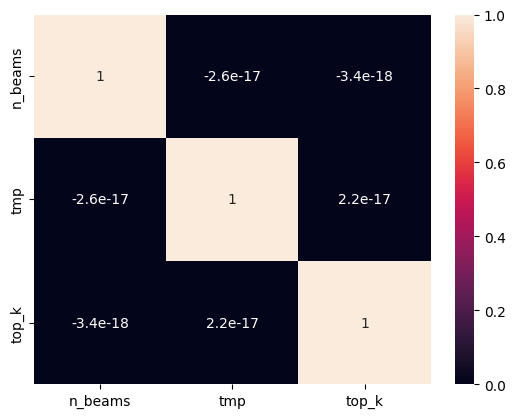

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df[['n_beams', 'tmp', 'top_k']].corr(), annot=True)
plt.show()